

## 🩺 COVID-19 Detection from CT Scan Images using TensorFlow

### 📌 Project Overview

This project focuses on detecting **COVID-19 from chest CT scan images** using deep learning techniques. A convolutional neural network (CNN) model is developed and trained using **TensorFlow** to classify CT images and assist in automated medical image analysis.

The project is based on the **COVIDx CT dataset** available on Kaggle and aims to demonstrate how deep learning can support medical diagnosis by analyzing CT scan data.

### 📂 Dataset

* **Dataset Source:** COVIDx CT Dataset (Kaggle)  https://www.kaggle.com/datasets/hgunraj/covidxct
* **Data Type:** Chest CT scan images
* **Classes:** COVID-19 positive and non-COVID cases
* The dataset contains labeled CT images collected from real clinical cases.

### 🧠 Model & Approach

* Built using **TensorFlow** and **Keras**
* A **Convolutional Neural Network (CNN)** architecture is used for image classification
* Image preprocessing steps include resizing, normalization, and data augmentation
* The model is trained to learn discriminative features from CT images to identify COVID-19 infections


In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
DATA_DIR = "data"
IMAGE_DIR = os.path.join(DATA_DIR, "3A_images")

TRAIN_TXT = os.path.join(DATA_DIR, "train_COVIDx_CT-3A.txt")
VAL_TXT   = os.path.join(DATA_DIR, "val_COVIDx_CT-3A.txt")
TEST_TXT  = os.path.join(DATA_DIR, "test_COVIDx_CT-3A.txt")


In [3]:
def load_txt_to_df(txt_path):
    filenames = []
    labels = []

    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 6:
                continue

            fname, cls, _, _, _, _ = parts[:]
            cls = int(cls)

            label = 1 if cls == 2 else 0

            filenames.append(fname)
            labels.append(label)

    df = pd.DataFrame({
        "filename": filenames,
        "label": labels
    })

    df["path"] = df["filename"].apply(lambda x: os.path.join(IMAGE_DIR, x))
    return df

In [4]:
train_df = load_txt_to_df(TRAIN_TXT)
val_df   = load_txt_to_df(VAL_TXT)
test_df  = load_txt_to_df(TEST_TXT)

In [5]:
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
all_df = shuffle(all_df, random_state=1988).reset_index(drop=True)

In [6]:
all_df.shape

(425024, 3)

### For running the model on the system here, I have limited the number of samples in the train/test split. By using a GPU, the full dataset can be used.

In [7]:
train_df = all_df.iloc[:4000].reset_index(drop=True)
val_df   = all_df.iloc[4000:5000].reset_index(drop=True)
test_df  = all_df.iloc[5000:6000].reset_index(drop=True)

In [8]:
len(train_df), len(val_df), len(test_df)


(4000, 1000, 1000)

In [9]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

In [11]:
def make_dataset(df, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(
        (df["path"].values, df["label"].values)
    )
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


In [12]:
train_ds = make_dataset(train_df, shuffle=True)
val_ds   = make_dataset(val_df)
test_ds  = make_dataset(test_df)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, CSVLogger
from tensorflow.keras.optimizers import Adam
import datetime


model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPool2D(2),

    Conv2D(64, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPool2D(2),

    Conv2D(128, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPool2D(2),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

optimizer = Adam(learning_rate=1e-4)  # stable learning rate
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

csv_logger = CSVLogger("training_log.csv", append=True)

callbacks = [early_stop, tensorboard_cb, csv_logger]


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)


test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch 1/50


/Users/mohammadshafiei/Desktop/project/.pixi/envs/default/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 766ms/step - accuracy: 0.8142 - loss: 0.6968 - val_accuracy: 0.7140 - val_loss: 4.2889
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 807ms/step - accuracy: 0.8992 - loss: 0.2692 - val_accuracy: 0.7140 - val_loss: 4.2419
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 98s 770ms/step - accuracy: 0.9240 - loss: 0.2070 - val_accuracy: 0.7370 - val_loss: 1.4818
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 750ms/step - accuracy: 0.9427 - loss: 0.1524 - val_accuracy: 0.7840 - val_loss: 0.6561
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 93s 731ms/step - accuracy: 0.9567 - loss: 0.1135 - val_accuracy: 0.9140 - val_loss: 0.2063
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 746ms/step - accuracy: 0.9657 - loss: 0.0912 - val_accuracy: 0.9400 - val_loss: 0.1411
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 93s 734ms/step - accuracy: 0.9695 - loss: 0.0794 - val_accuracy: 0.9370 - val_loss: 0.1605
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 93s 731ms/step - accuracy: 0.9810 - loss: 0.0565 - v

In [14]:
log = pd.read_csv("training_log.csv")
log.tail()


,epoch,accuracy,loss,val_accuracy,val_loss
15,4,0.95675,0.113466,0.914,0.206264
16,5,0.96575,0.091168,0.940,0.141087
17,6,0.96950,0.079386,0.937,0.160488
18,7,0.98100,0.056480,0.900,0.298125
19,8,0.97700,0.061566,0.928,0.204636


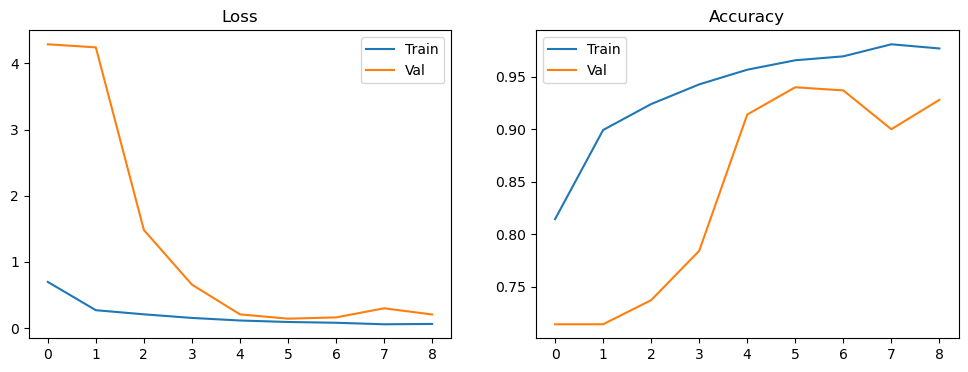

In [15]:
plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.show()


In [17]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

print(classification_report(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2026-01-21 19:00:12.907873: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    preds = (preds > 0.5).astype(int)   # threshold = 0.5

    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())


2026-01-21 19:09:13.716890: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[211  37]
 [ 13 739]]


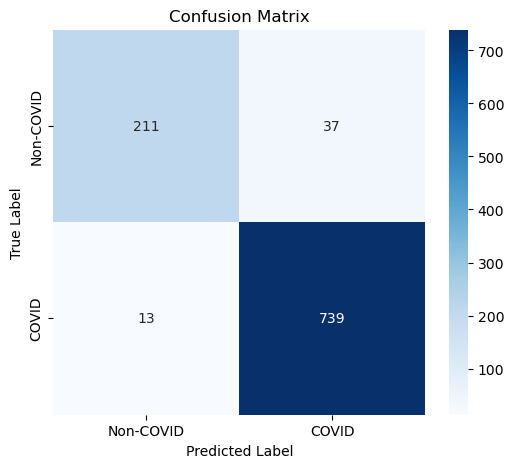

In [21]:
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non-COVID", "COVID"],
    yticklabels=["Non-COVID", "COVID"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [22]:
model.save("covid_ct_model.h5")
